In [3]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import matplotlib.pyplot as plt
from keras.models import Model
from matplotlib import pyplot
from keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from numpy import fft
import keras
from keras import optimizers
#from keras_self_attention import SeqSelfAttention
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [41]:
# Download the Human_Activity_Recognition Dataset from the link: https://drive.google.com/drive/folders/1dZKbFSHg-991Dwt7jD3FjyJwCZSrLHoZ?usp=drive_link
# Upload the dataset in your drive
# Make a copy of this colab file in your drive
# Open the copied file and run

**# Activities**

In [17]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

**# Input features**

In [19]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [21]:
# Path of the UCI_HAR_Dataset from mounted drive
DATADIR = '/content/drive/MyDrive/UCI_HAR_Dataset'

In [22]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

In [25]:
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        )
    return np.transpose(signals_data, (1, 2, 0))

**# One hot encoding of labels**

In [27]:
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [28]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, y_train, X_test,  y_test

In [29]:
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

In [30]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [31]:
# Loading the train and test data
X_train, Y_train, X_test,  Y_test = load_data()

<ipython-input-22-b09913bd9c88>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-22-b09913bd9c88>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-22-b09913bd9c88>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-22-b09913bd9c88>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(filename, delim_whitespace=True, header=None)
<ipython-input-22-b09913

In [32]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)
#n_classes  = 6
print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [35]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(128,9)))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,950 (58.40 KB)

 Trainable params: 14,950 (58.40 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
hist1=model.fit(X_train,
          Y_train,
          batch_size=64,
          epochs=10,
            callbacks=[es],
               validation_split=0.2)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3415 - loss: 1.5644 - val_accuracy: 0.6710 - val_loss: 0.9166
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6642 - loss: 0.7855 - val_accuracy: 0.6764 - val_loss: 0.7939
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7024 - loss: 0.6454 - val_accuracy: 0.7016 - val_loss: 0.7710
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7369 - loss: 0.5981 - val_accuracy: 0.7621 - val_loss: 0.6522
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8018 - loss: 0.4518 - val_accuracy: 0.7947 - val_loss: 0.5953
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8506 - loss: 0.3698 - val_accuracy: 0.7702 - val_loss: 0.6710
Epoch 6: early stopping


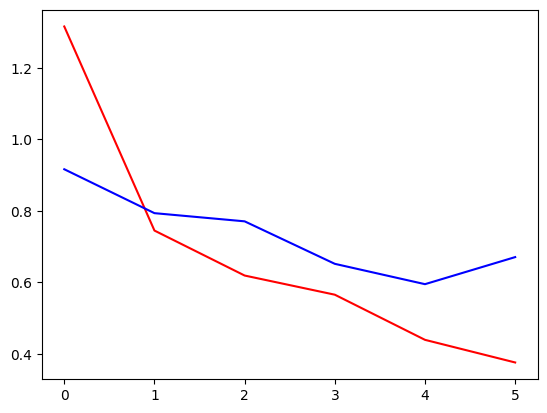

In [39]:
plt.plot(hist1.history['loss'],'r')
plt.plot(hist1.history['val_loss'],'b')

In [40]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [ ]:
print(confusion_matrix(Y_test, model.predict(X_test)))

93/93 [==============================] - 3s 24ms/step
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 508        0         0        1                   1   
SITTING                  0      432        37       21                   0   
STANDING                 0      136       380       16                   0   
WALKING                  0        0        67      357                   2   
WALKING_DOWNSTAIRS       0        0         4      187                  15   
WALKING_UPSTAIRS         0        0         1      140                   8   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            1  
STANDING                           0  
WALKING                           70  
WALKING_DOWNSTAIRS               214  
WALKING_UPSTAIRS                 322  
